# ResNet 논문 구현
## [Deep Residual Learning for Image Recognition]


# Hyper-parameter
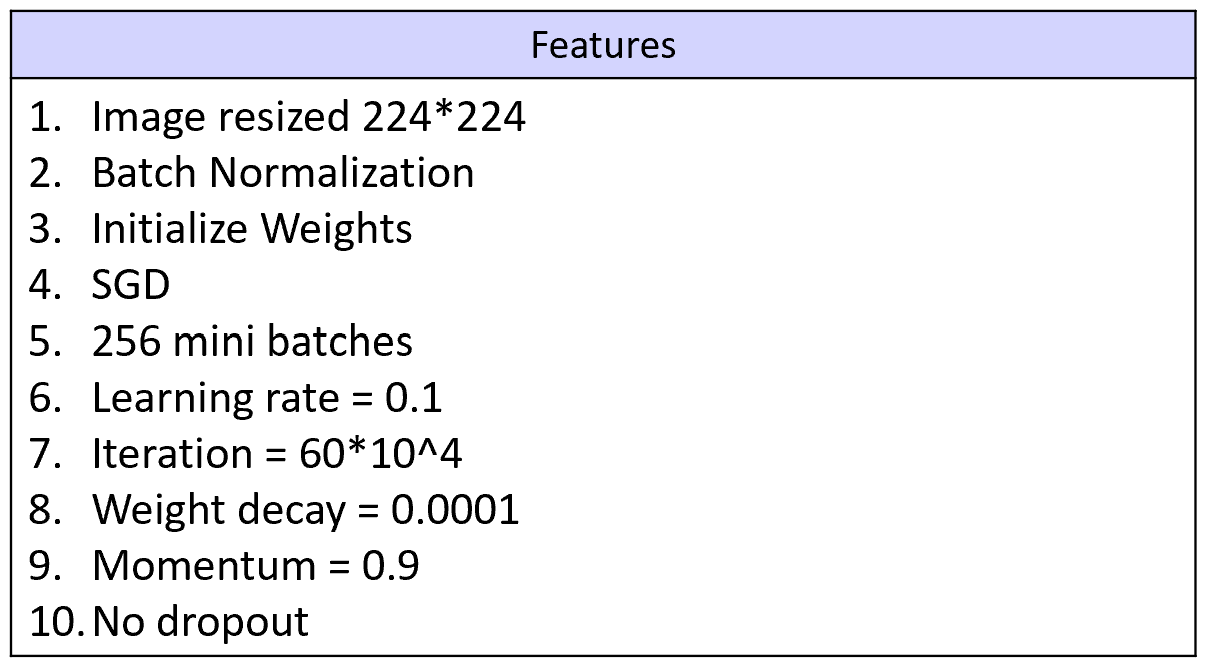

# ResNet 구조
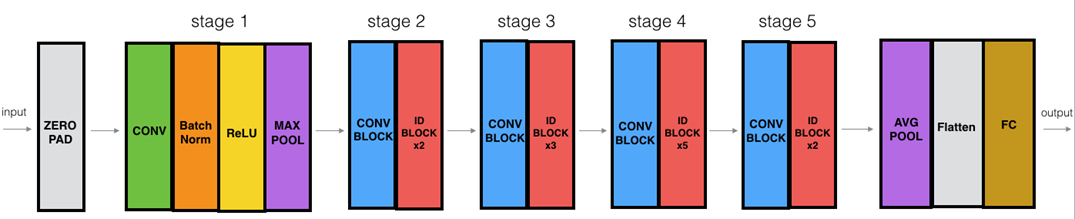

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

partition = {'train': train_dataset, 'val': val_dataset}

100%|██████████| 170498071/170498071 [00:01<00:00, 92335836.68it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [2]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, out_planes, stride)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = conv3x3(out_planes, out_planes)
        self.bn2 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])


In [6]:
def train(model, dataset, optimizer, criterion, batch_size):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in dataloader:
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(dataloader)
    train_acc = 100 * correct / total

    return train_loss, train_acc


Epoch 1/10, Train Loss: 1.3489, Train Acc: 50.76%
Epoch 2/10, Train Loss: 0.8688, Train Acc: 69.28%
Epoch 3/10, Train Loss: 0.6506, Train Acc: 77.19%
Epoch 4/10, Train Loss: 0.5114, Train Acc: 82.15%
Epoch 5/10, Train Loss: 0.3995, Train Acc: 86.09%
Epoch 6/10, Train Loss: 0.3091, Train Acc: 89.25%
Epoch 7/10, Train Loss: 0.2337, Train Acc: 91.65%
Epoch 8/10, Train Loss: 0.1698, Train Acc: 94.02%
Epoch 9/10, Train Loss: 0.1192, Train Acc: 95.78%
Epoch 10/10, Train Loss: 0.0972, Train Acc: 96.62%


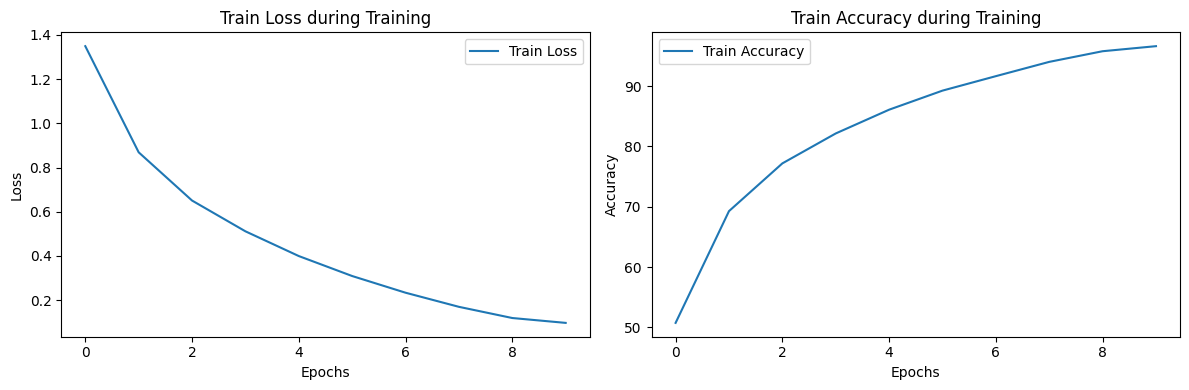

In [7]:
import matplotlib.pyplot as plt

num_epochs = 10
learning_rate = 0.001
train_batch_size = 64

model = ResNet18()
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_loss_list = []
train_accuracy_list = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, partition['train'], optimizer, criterion, train_batch_size)

    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_acc)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss during Training')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy during Training')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/10, Train Loss: 1.4014, Train Error Rate: 51.08%
Epoch 2/10, Train Loss: 0.9034, Train Error Rate: 32.05%
Epoch 3/10, Train Loss: 0.6823, Train Error Rate: 24.28%
Epoch 4/10, Train Loss: 0.5330, Train Error Rate: 18.59%
Epoch 5/10, Train Loss: 0.4182, Train Error Rate: 14.55%
Epoch 6/10, Train Loss: 0.3241, Train Error Rate: 11.35%
Epoch 7/10, Train Loss: 0.2367, Train Error Rate: 8.29%
Epoch 8/10, Train Loss: 0.1722, Train Error Rate: 6.05%
Epoch 9/10, Train Loss: 0.1265, Train Error Rate: 4.38%
Epoch 10/10, Train Loss: 0.1017, Train Error Rate: 3.64%


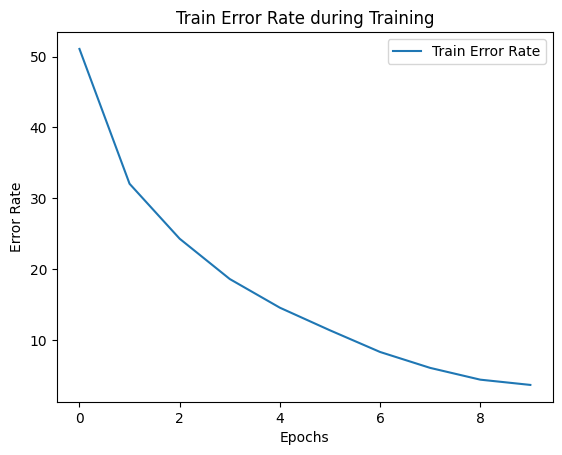

In [8]:
# Training parameters
num_epochs = 10
learning_rate = 0.001
train_batch_size = 64

# Initialize ResNet model, optimizer, and criterion
model = ResNet18()
model = model.cuda()  # If you're using a GPU
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# List to keep track of training progress
train_error_rate_list = []

# Training loop
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, partition['train'], optimizer, criterion, train_batch_size)
    train_error_rate = 100 - train_acc

    # Save training results
    train_error_rate_list.append(train_error_rate)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Error Rate: {train_error_rate:.2f}%")

# Plot training results
plt.figure()
plt.plot(train_error_rate_list, label='Train Error Rate')
plt.xlabel('Epochs')
plt.ylabel('Error Rate')
plt.title('Train Error Rate during Training')
plt.legend()

plt.show()
